In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
import astropy.units as u
import importlib
from astropy.modeling import models, fitting



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/yz_cmi/'
stis_specs = glob.glob('{}hst/stis/*x1d.fits'.format(path))
cos_specs = glob.glob('{}hst/cos/*x1dsum.fits'.format(path))
print(cos_specs)

['/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7111010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7109010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf71z9010_x1dsum.fits']


In [22]:
# # fig, ax = plt.subplots()

# for x in np.hstack((stis_specs, cos_specs)):
#     fig, ax = plt.subplots()
    
#     data = fits.getdata(x, 1)
#     for dt in data[::-1]:
#         w, f, e = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'] 
#         # ax.step(dt['WAVELENGTH'], dt['FLUX'])
#         # mask = (w < 1120) | w < 1160
#         ax.step(w, f, where='mid')
#     ax.set_yscale('log')

1163.3911 2835.337
1065.5724 1545.3041
1778.1298 2022.7762
2302.9382 3072.4956


(1750.0, 2100.0)

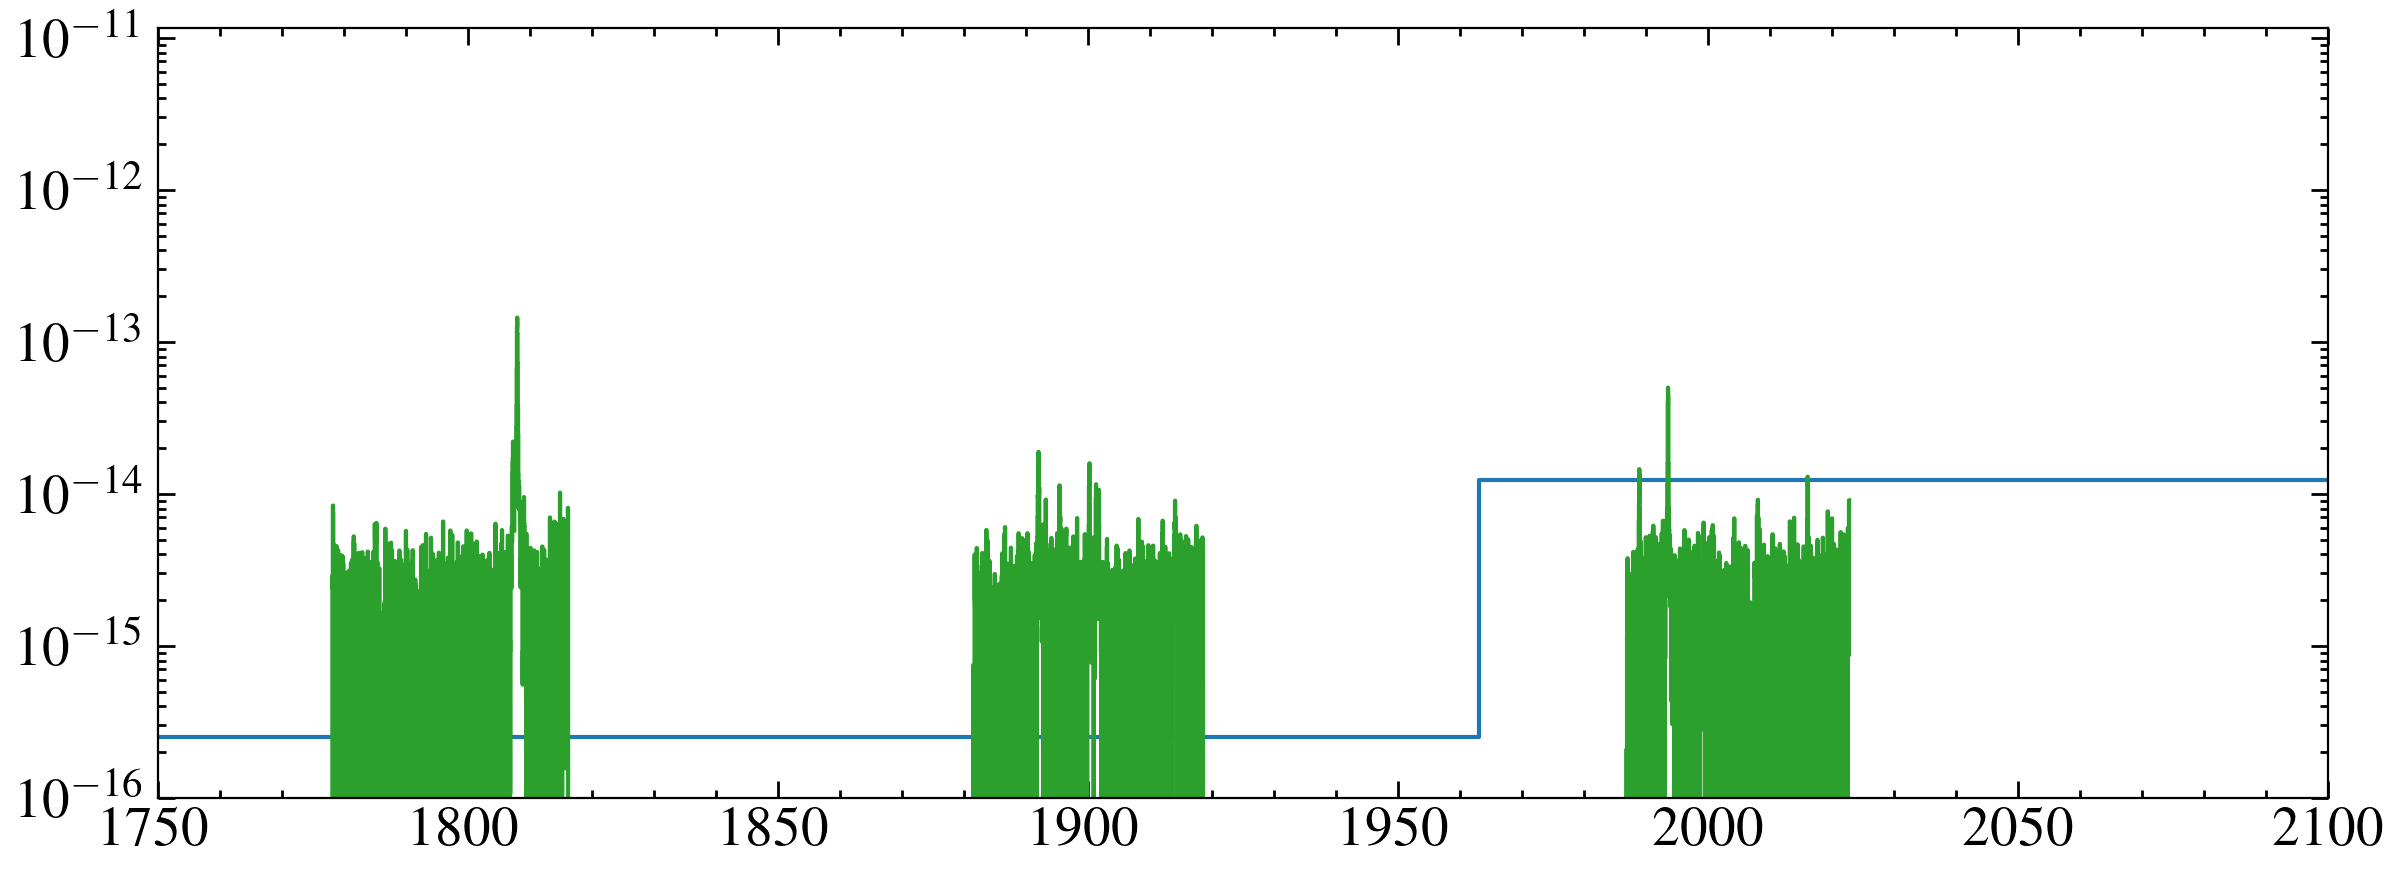

In [24]:
cspecs = glob.glob('{}hst/cspecs/*cspec.fits'.format(path))

fig, ax = plt.subplots()
for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid')
    print(w[0], w[-1])

# g185mpath = '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7111010_x1dsum.fits'
# g185m = fits.getdata(g185mpath, 1)
# for data in g185m:
#     # data = fits.getdata(x, 1)
#     w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     f = convolve(f, kernel=Box1DKernel(5))
#     ax.step(w, f, where='mid')

ax.set_yscale('log')
ax.set_ylim(1e-16)

ax.set_xlim(1750, 2100)

Why did HASP not include the G185M spectrum? Fixed. Might need to write a little HASP to MUSCLES routine

Lots of gaps but clearly detected continuumn, might have to fit something. Nope, it has been done!

In [5]:
contpath = '{}cont/UVcont_estimate_YZCMi_080525.txt'.format(path)
cont = Table.read(contpath, format='csv')
cont.dtype.names

('Wave', 'Cont Flux', 'Cont Err', 'Conf Fit')

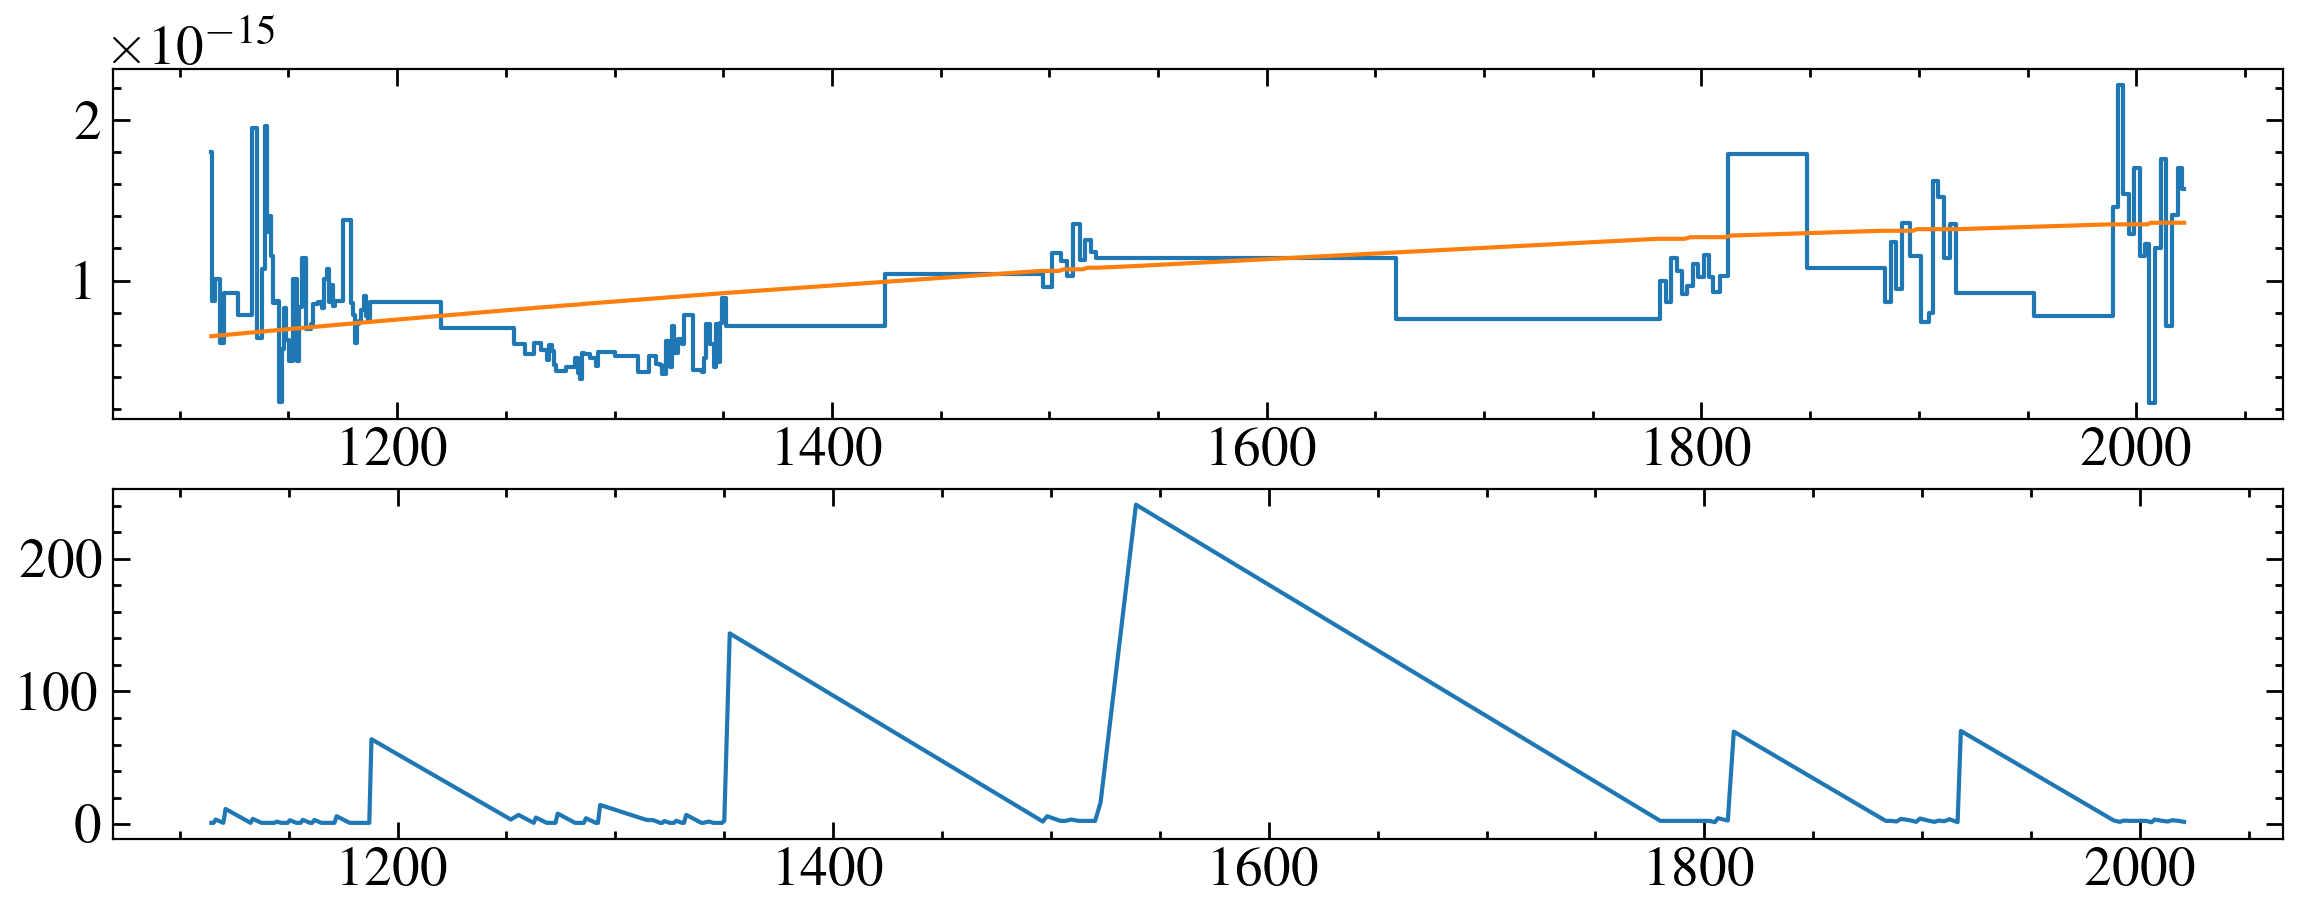

In [16]:
fig, ax = plt.subplots(nrows=2)
ax[0].step(cont['Wave'], cont['Cont Flux'], where='mid')
ax[0].plot(cont['Wave'], cont['Conf Fit'])

ax[1].plot(cont['Wave'][:-1], np.diff(cont['Wave']))

Need to extend cont out to 2300, do it with a flat line for now.

(1e-16, np.float64(1.1661496038735405e-11))

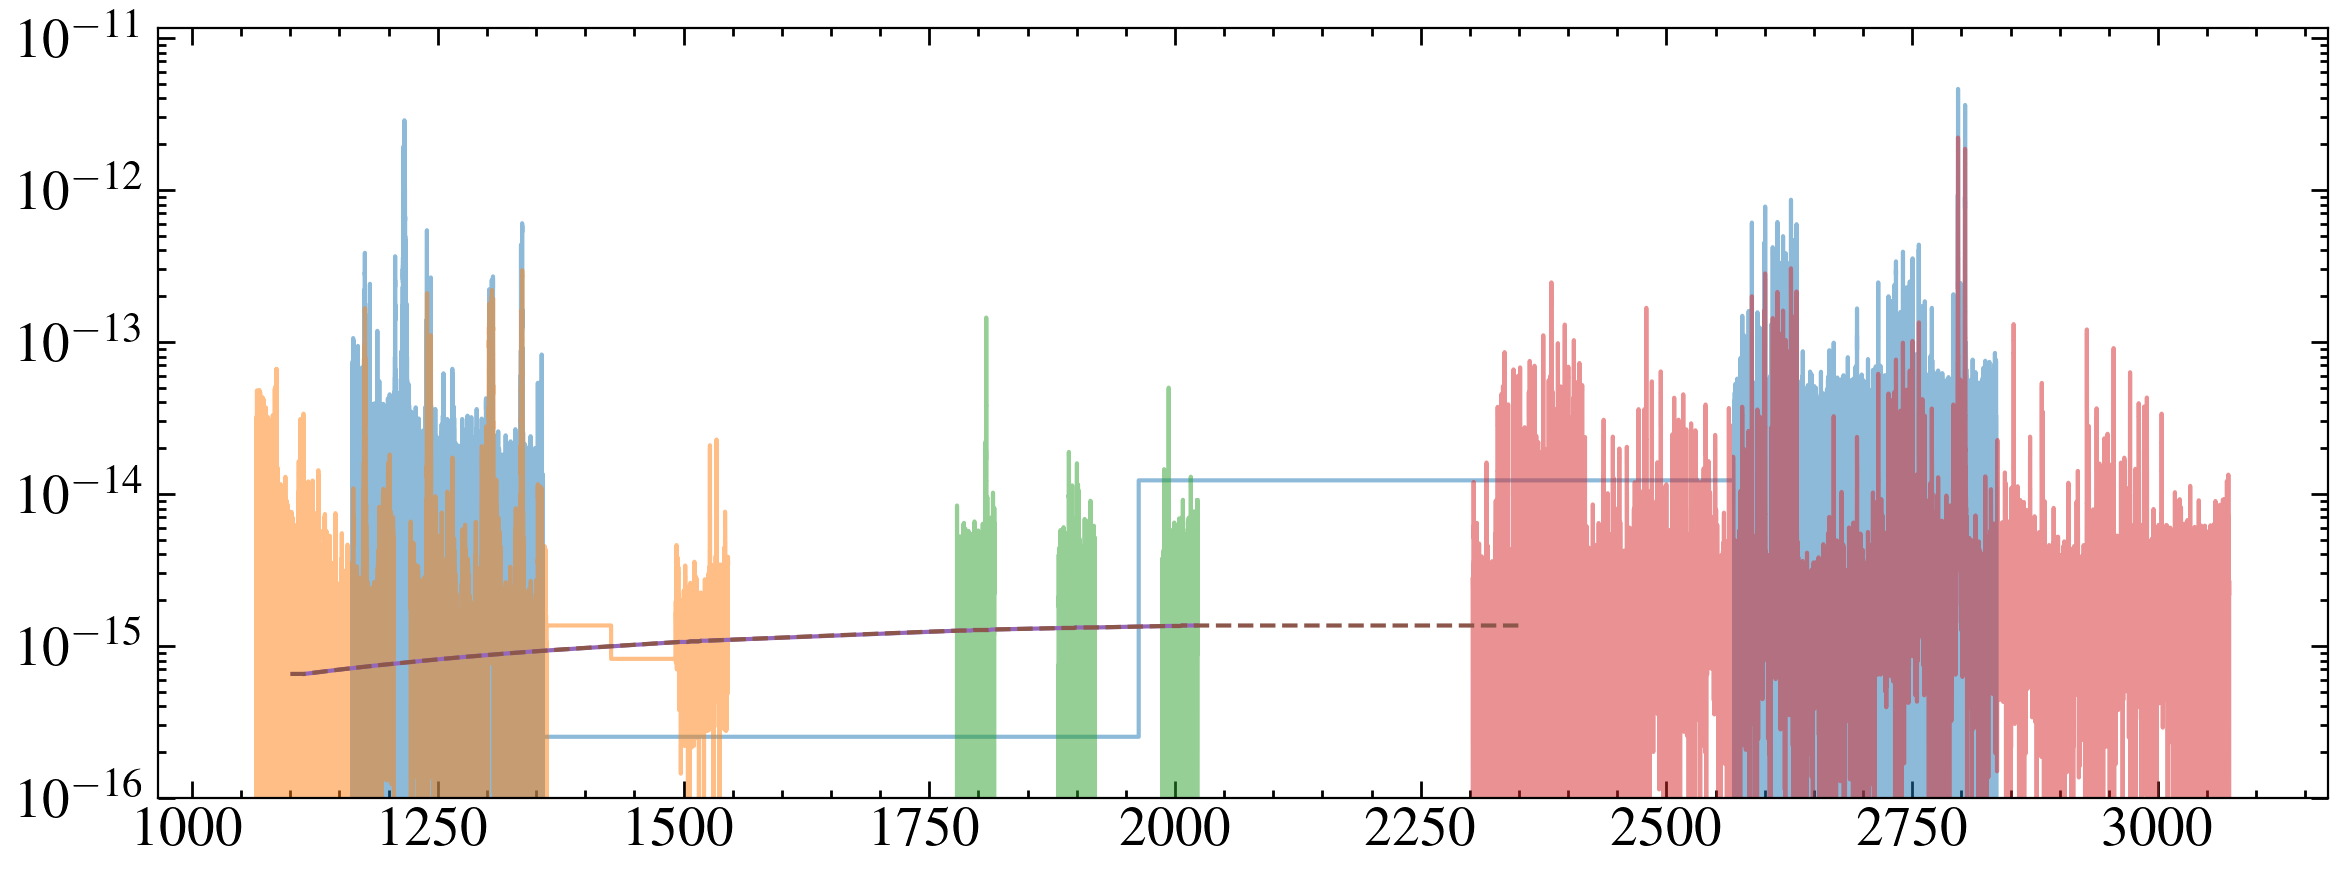

In [31]:

fig, ax = plt.subplots()
for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)
    # print(w[0])

# g185mpath = '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7111010_x1dsum.fits'
# g185m = fits.getdata(g185mpath, 1)
# for data in g185m:
#     # data = fits.getdata(x, 1)
#     w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     f = convolve(f, kernel=Box1DKernel(5))
#     ax.step(w, f, where='mid')

ax.plot(cont['Wave'], cont['Conf Fit'])
cw = np.arange(1100, 2351, 1)
cf = np.interp(cw, cont['Wave'], cont['Conf Fit'])
ax.plot(cw, cf, ls='--')


ax.set_yscale('log')
ax.set_ylim(1e-16)

# ax.set_xlim(1750, 2100)
# ax.set_xlim(1290, 1300)

Ok that works. Use the COS + G230M data, higher S/N. Could also use Kevin's line list?

In [33]:
lines = Table.read('{}cont/DEM_goodlinelist_YZCMi.csv'.format(path))
# lines = lines[lines['Flux'] != 0.0]
lines = lines[lines['Flux'] > 0.0]
lines

Ion,Wavelength,Likelihood to measure,Log Formation Temperature,col4,Flux,Flux_Err
str6,float64,str6,float64,int64,float64,float64
Fe XIX,1118.057,Low,6.9,--,2.45e-15,5.15e-16
Ne V,1145.596,Medium,5.5,--,1.02e-15,3.18e-16
C III,1175.713,High,4.9,--,1.37e-13,2.51e-15
N V,1238.821,High,5.3,--,6.21e-14,5.2e-16
N V,1242.804,High,5.3,--,3.16e-14,4.4e-16
S II,1253.811,Medium,4.5,--,1.25e-15,4.61e-17
S II,1259.519,Medium,4.5,--,1.66e-15,8.31e-17
Si II,1260.417,Medium,4.5,--,2.1e-15,6.8e-17
Si II,1264.737,High,4.5,--,4.53e-15,1.07e-16


(-1e-14, 1e-13)

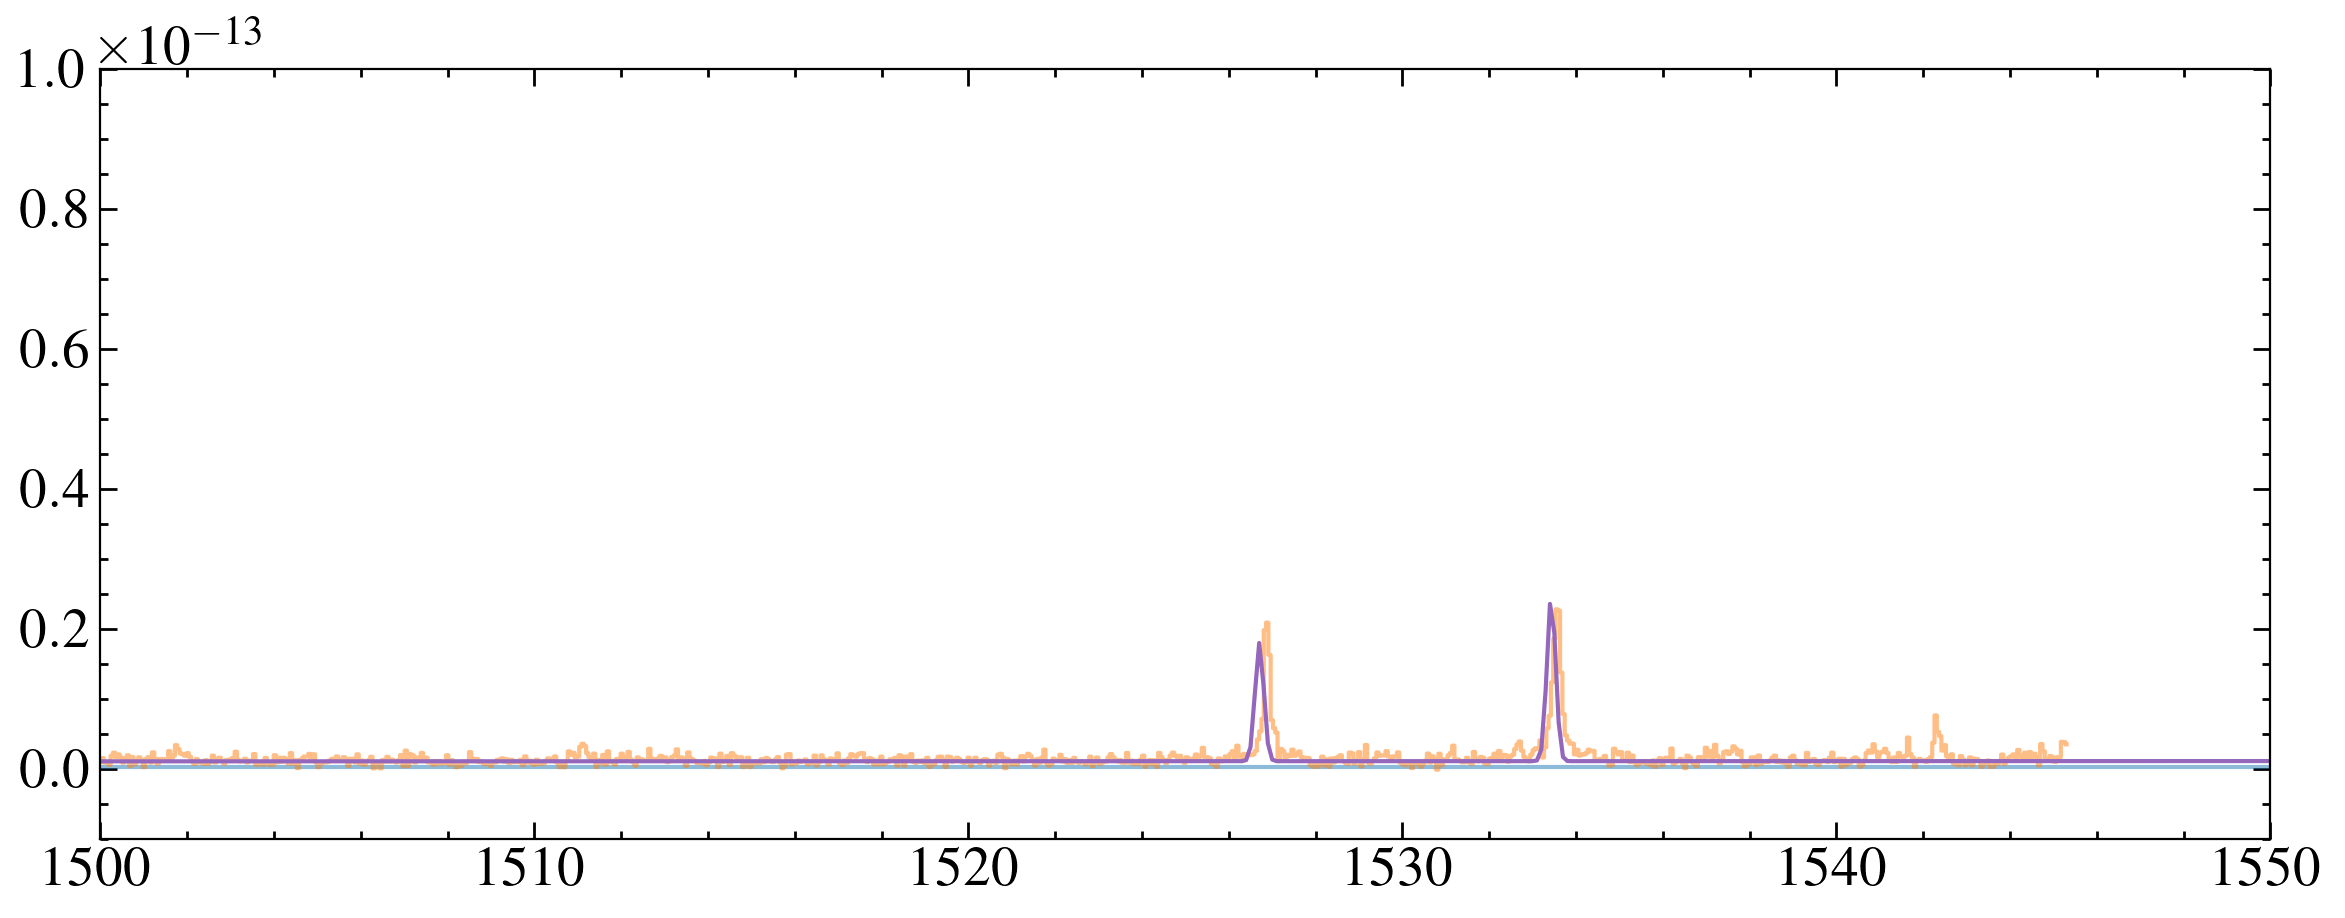

In [60]:
fig, ax = plt.subplots()


for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)

std = 0.1
cw = np.arange(1100, 2351, 0.1)
cf = np.interp(cw, cont['Wave'], cont['Conf Fit'])
for line in lines:
    wline = line['Wavelength']
    fline = line['Flux']
    eline = line['Flux_Err']

    amp = fline / (std * (2* np.pi)**0.5)
    mod = models.Gaussian1D(amp, wline, std)
    mod = mod(cw)

    cf += mod

ax.plot(cw, cf)
# ax.set_xlim(1220, 2000)
# ax.set_xlim(1270, 1300)
ax.set_xlim(1500, 1550)
ax.set_ylim(-1e-14, 1e-13)

(0.0, 1e-14)

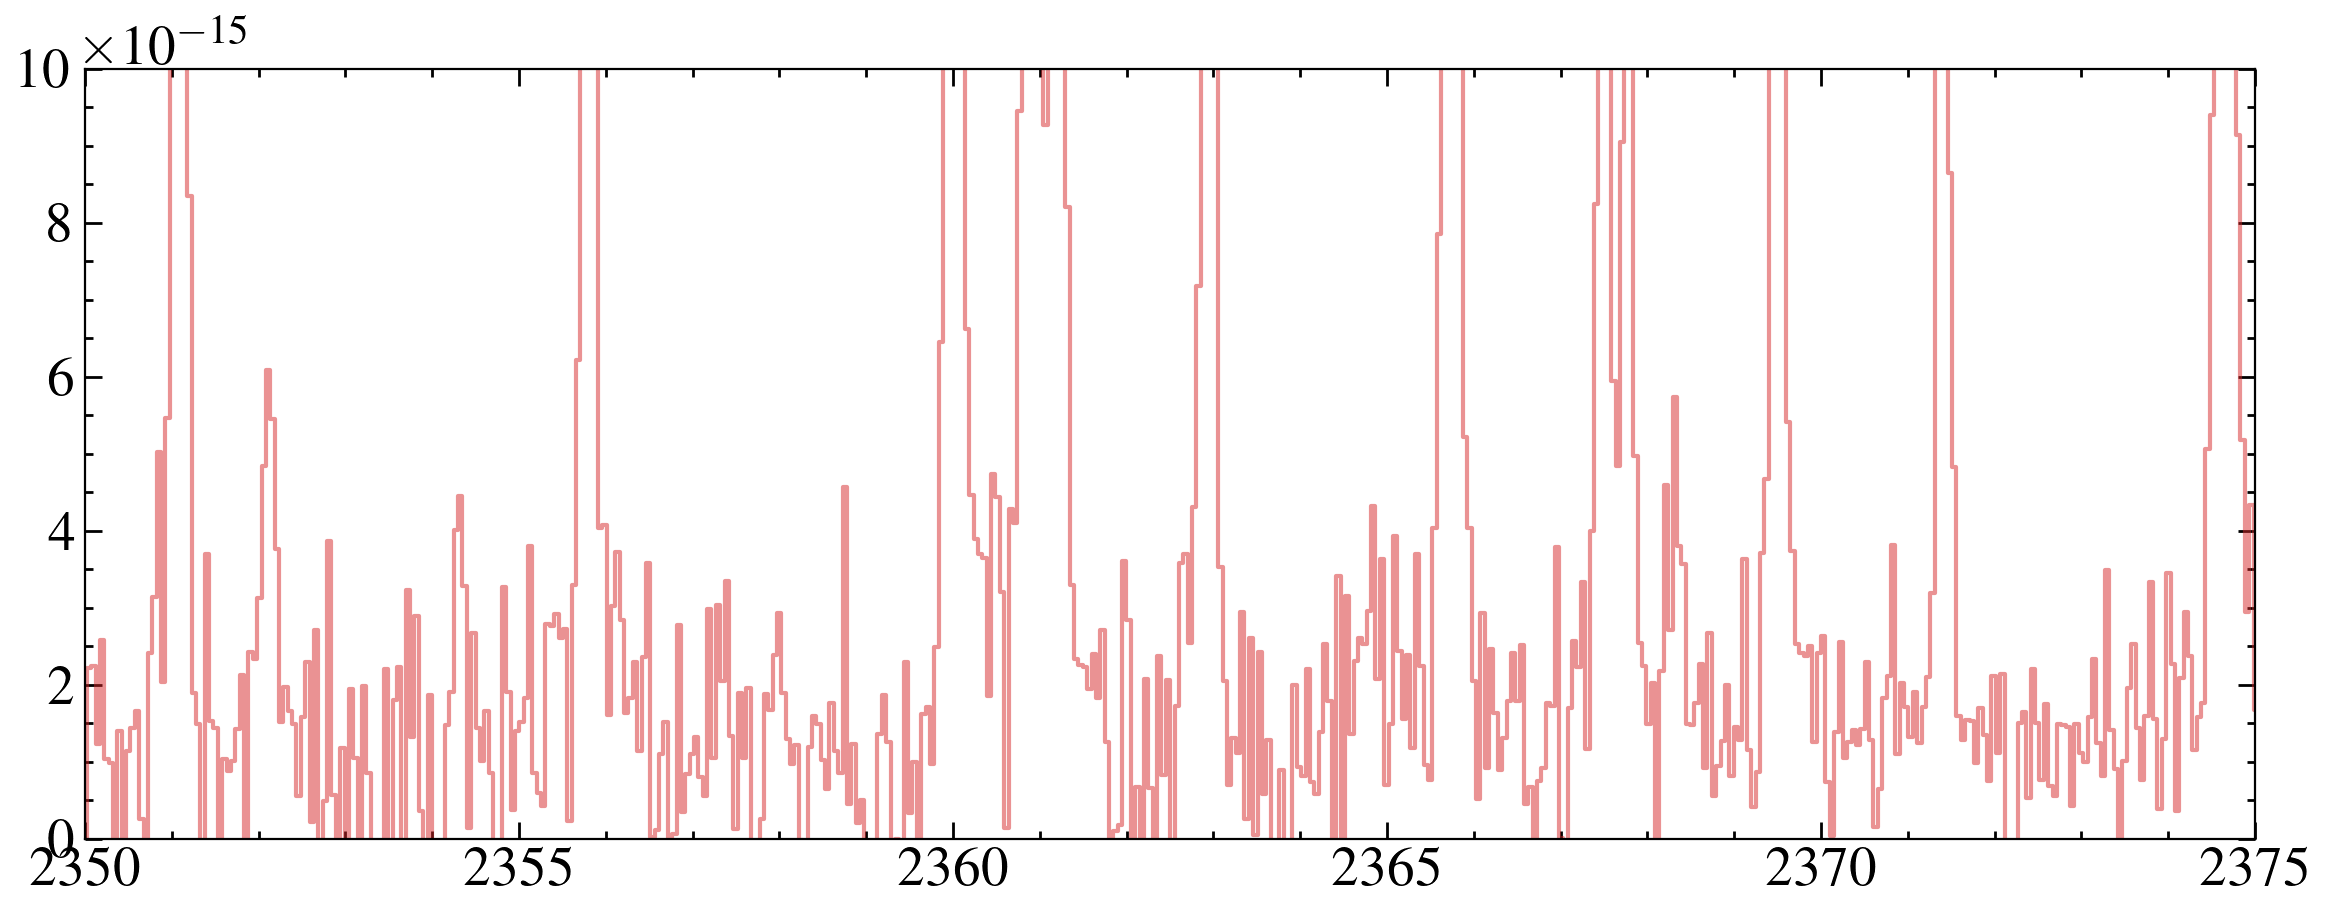

In [59]:
fig, ax = plt.subplots()


for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)

ax.set_xlim(2350, 2375)
ax.set_ylim(0, 0.1e-13)

Draft HASP to MUSCLES, add Lya, add DEM, convert RGS spectrum to flux, grab and check PHX, combine!